<a href="https://colab.research.google.com/github/feelzoo/Ecommerce_Freeshipping_Threshold_Shipping_Rates_Results/blob/main/AOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Free Shipping Threshold & Shipping Rates for Ecommerce Result Report**

### I perfomred a statistical analysis to measure the effect of our new shipping plans on our ecommerce business. 

# 1. **Background**
Our company made two major changes on our shipping plan as below in order to not only cover the soaring supply chain costs but also increase Average Order Value while maintaining customer satisfaction.

**Previous plan: \$50 threshold for free standard shipping / \$5 standard shipping free for orders under \$50**<br>
**New plan: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\$75 threshold for free standard shipping/ \$5.95 standard shipping price for orders under $75**

I conducted a data anlaysis to examine the effect of our new plan on our AOV and conversion rate since these two metrics are highly correlated with shipping methods and rates

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.animation as ani
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pd.set_option('display.max_rows',10,'display.max_columns',None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/NADRI/Shopify_Order_Product_Returns' 

Mounted at /content/gdrive


In [20]:
order1 = f'{root_path}/orders_export_2.csv'
order2 = f'{root_path}/orders_export_1 2.csv'

orders_all = pd.concat(map(pd.read_csv,[order1,order2]),ignore_index = True)

conversion = pd.read_csv(f"{root_path}/conversion_rate.csv")
conv_day = pd.read_csv(f"{root_path}/conversion_day.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:304: DtypeWarning: Columns (45,71) have mixed types.Specify dtype option on import or set low_memory=False.
  sort=sort,


In [4]:
def cat2(x):
  bounds = list(range(50,200,25))
  if x < bounds[0]:
    return f'<${bounds[0]}'
  if x>=bounds[-1]:
    return f'{bounds[-1]}over'
  for i in range(len(bounds)-1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'

In [5]:
def year_month(data):
    data['year'] = ''
    data['month'] = ''
    for index, row in data.iterrows():
        try: 
            year = str(row['Created at']).split('-')[0]
            month = str(row['Created at']).split('-')[1]
        except: 
            year = '0'
            month = '0'
        data.at[index,'year'] = year
        data.at[index,'month'] = month

In [25]:
def year_month_day(data):
  data['year'] =''
  data['month'] =''
  data['d'] =''
  for index, row in data.iterrows():
    try:
      year = str(row['day']).split('-')[0]
      month = str(row['day']).split('-')[1]
      day = str(row['day']).split('-')[2]
    except:
      year = '0'
      month = '0'
      day = '0'
    data.loc[index,'year'] = year
    data.loc[index,'month'] = month
    data.loc[index,'d'] = day

#2. **Dataset**
Year-over-year Shopify order data was used to mitigate seasonality. 


In [6]:
year_month(orders_all)

In [7]:
#Slice data for January 2021
jan_feb_2020 = orders_all[(((orders_all['year'] == '2020') & (orders_all['month'] == '01'))| ((orders_all['month'] =='02') & (orders_all['year'] == '2020'))) & (orders_all['Name'] != 'N8350')]
jan_2021 = orders_all[(orders_all['year'] == '2021') & (orders_all['month'] == '01') & (orders_all['Name'] != 'N8350')]
jan_feb_2021 = orders_all[(((orders_all['year'] == '2021') & (orders_all['month'] == '01'))| ((orders_all['month'] =='02') & (orders_all['year'] == '2021'))) & (orders_all['Name'] != 'N8350')]
#Group Name,Total,Quantity for January 2021
jan_feb_2020_group = jan_feb_2020.groupby(['Name','Total'])['Lineitem quantity'].sum().reset_index()
jan_2021_group = jan_2021.groupby(['Name','Total'])['Lineitem quantity'].sum().reset_index()
jan_feb_2021_group = jan_feb_2021.groupby(['Name','Total'])['Lineitem quantity'].sum().reset_index()

In [8]:
#Compute total revenue and AVO for January&February 2020
avg_2020_jan_feb = jan_feb_2020_group['Total'].sum()/len(jan_feb_2020_group)
total_2020_jan_feb = jan_feb_2020_group['Total'].sum()

#Compute total revenue and AOV for January 2021
avg_2021_jan = jan_2021_group['Total'].sum()/len(jan_2021_group)
total_2021_jan = jan_2021_group['Total'].sum()

#Compute total revenue and AVO for January&February 2021
avg_2021_jan_feb = jan_feb_2021_group['Total'].sum()/len(jan_feb_2021_group)
total_2021_jan_feb = jan_feb_2021_group['Total'].sum()

In [9]:
#Import data for January 2022
recent_data = pd.read_csv(root_path+'/2022_Jan_Feb_6.csv')
recent_data2 = pd.read_csv(root_path+'/2022_Jan_Feb.csv')
#Split date into year and month
year_month(recent_data)
year_month(recent_data2)

#Group data into Name,total,quantity
recent_group = recent_data.groupby(['Name','Total'])['Lineitem quantity'].sum().reset_index()
recent_group2 = recent_data2.groupby(['Name','Total'])['Lineitem quantity'].sum().reset_index()

In [10]:
#Compute total revenue and AOV for January 2022
avg_2022_jan = recent_group['Total'].sum()/len(recent_group)
total_2022_jan = recent_group['Total'].sum()

#Compute total revenue and AOV for January & February 2022
avg_2022_jan_feb = recent_group2['Total'].sum()/len(recent_group2)
total_2022_jan_feb = recent_group2['Total'].sum()

# a. **Financial Growth (AOV and Revenue) between old version vs new version**

In [11]:
stats= pd.DataFrame(columns = ['Version','AOV','Revenue'] , data = [['Old',avg_2021_jan_feb,total_2021_jan_feb],['New',avg_2022_jan_feb,total_2022_jan_feb]])

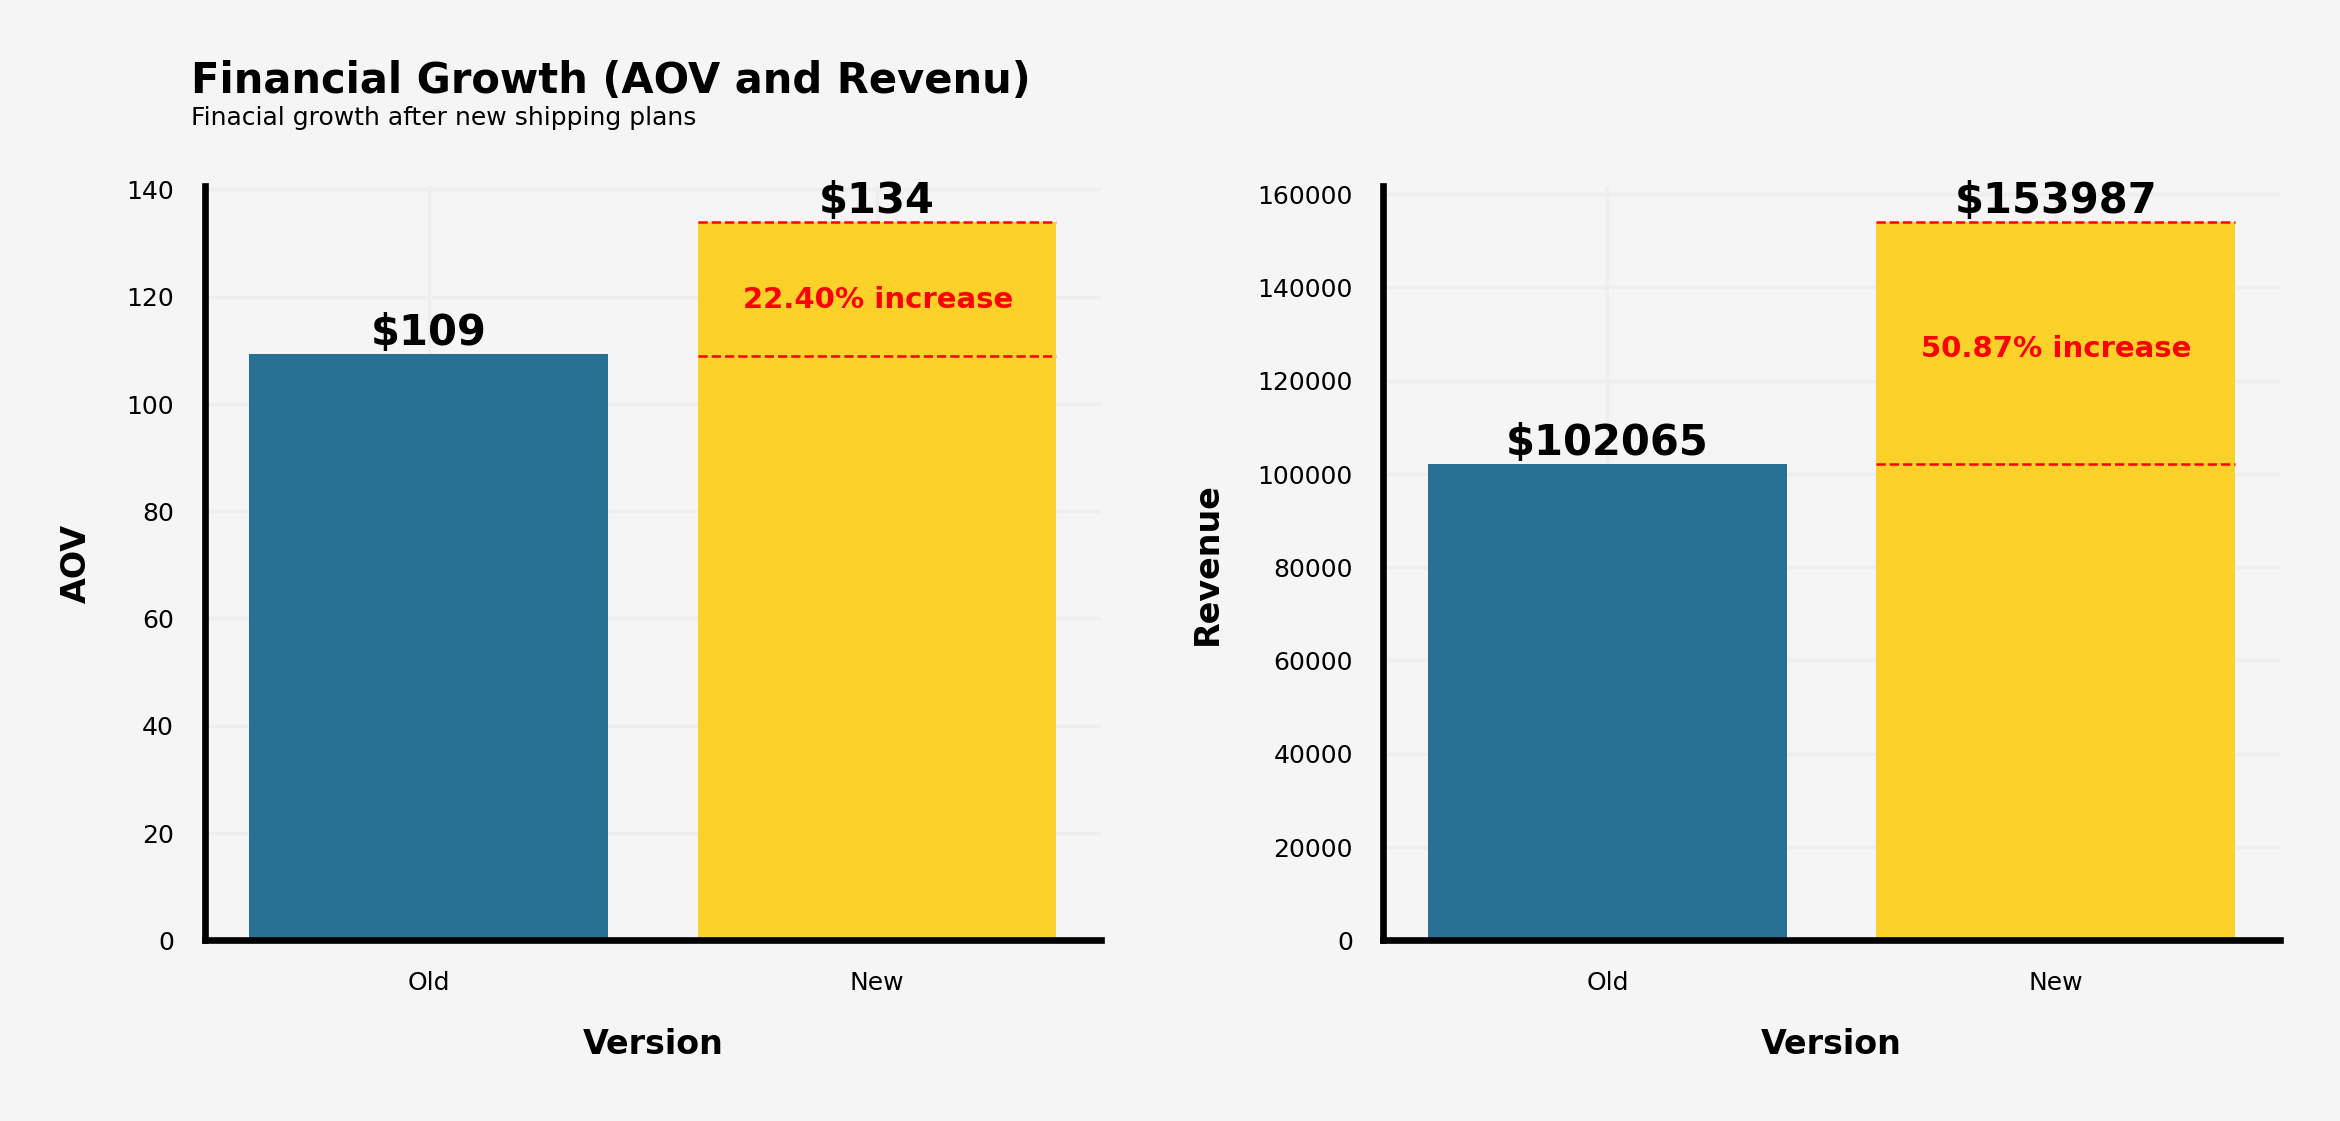

In [12]:
plt.rcParams['figure.dpi'] = 600
colors = ['#287094','#fcd12a']
fig = plt.figure(figsize= (4,2),facecolor =  '#f6f5f5')
background = '#f6f5f5'

location = 0 
for col in stats.columns[1:]:
  plt.subplot(1,2,location+1)
  ax = sns.barplot(data=stats, x='Version',y=col,palette=colors, alpha=1,saturation =1, zorder =2,linewidth = 0)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.set_facecolor(background)
  ax.grid(which = 'major',axis = 'x',zorder= 0, color='#EEEEEE',linewidth=.4)
  ax.grid(which = 'major',axis = 'y',zorder= 0, color='#EEEEEE',linewidth=.4)
  ax.set_xlabel('Version',fontsize = 4,fontweight='bold')
  ax.set_ylabel(col,fontsize = 4,fontweight='bold')
  ax.tick_params(labelsize=3,width=.5,length=.15)
  if col =='AOV':
    ax.text(-0.53,158,'Financial Growth (AOV and Revenu)',fontsize = 5,fontweight = 'bold')
    ax.text(-0.53,152,'Finacial growth after new shipping plans',fontsize = 3)
    ax.axhline(xmin =.55 ,xmax=.95 ,y=109,color='r',linewidth=.3,linestyle='dashed')
    ax.axhline(xmin =.55 ,xmax=.95 ,y=134,color='r',linewidth=.3,linestyle='dashed')
    ax.text(.7,118,'22.40% increase',fontsize=3.5,color='r',fontweight='bold')
  if col == 'Revenue':
    ax.axhline(xmin =.55 ,xmax=.95 ,y=102065,color='r',linewidth=.3,linestyle='dashed')
    ax.axhline(xmin =.55 ,xmax=.95 ,y=153987,color='r',linewidth=.3,linestyle='dashed')
    ax.text(.7,125000,'50.87% increase',fontsize=3.5,color='r',fontweight='bold')
  for p in ax.patches:
    value = f'${p.get_height():.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.text(x,y,value,fontsize = 5,fontweight='bold',ha='center',va='bottom')
    
  location=+1
plt.tight_layout()



## **- Is this difference in AOV statistically significant?**
### **Hypothesis Testing: 2 sample t-test**


In [13]:
old= jan_feb_2021_group['Total']
new=recent_group2['Total']
pd_old = pd.DataFrame(np.array(old),columns=['order_value'])
pd_new = pd.DataFrame(np.array(new),columns = ['order_value'])
pd_old['bins'] = pd_old['order_value'].apply(cat2)
pd_new['bins'] = pd_new['order_value'].apply(cat2)

In [14]:
new_line = '\n'
print(f'\033[1mSample Size\033[0m{new_line}Old Version:{len(old)}{new_line}New version:{len(new)}')

Sample Size
Old Version:933
New version:1150


In [15]:
ttst,pval = ttest_ind(old,new)
print(pval)

2.913347060779468e-07


#### **P-value of the 2-sample t-test is $2.91e^-7$. Thus, the difference in AOV is statistically siginficant using a significance threshold of 0.05.** 

### I diplayed two overlaid histograms below showing the amount of money spent per order by customers to the new and old versions as below to help you summarize the result and more fully interpret the statistical results of the hypothesis
   a. Count of the orders for each order value bin <br>
   b. Percentage of the orders for each order value bin

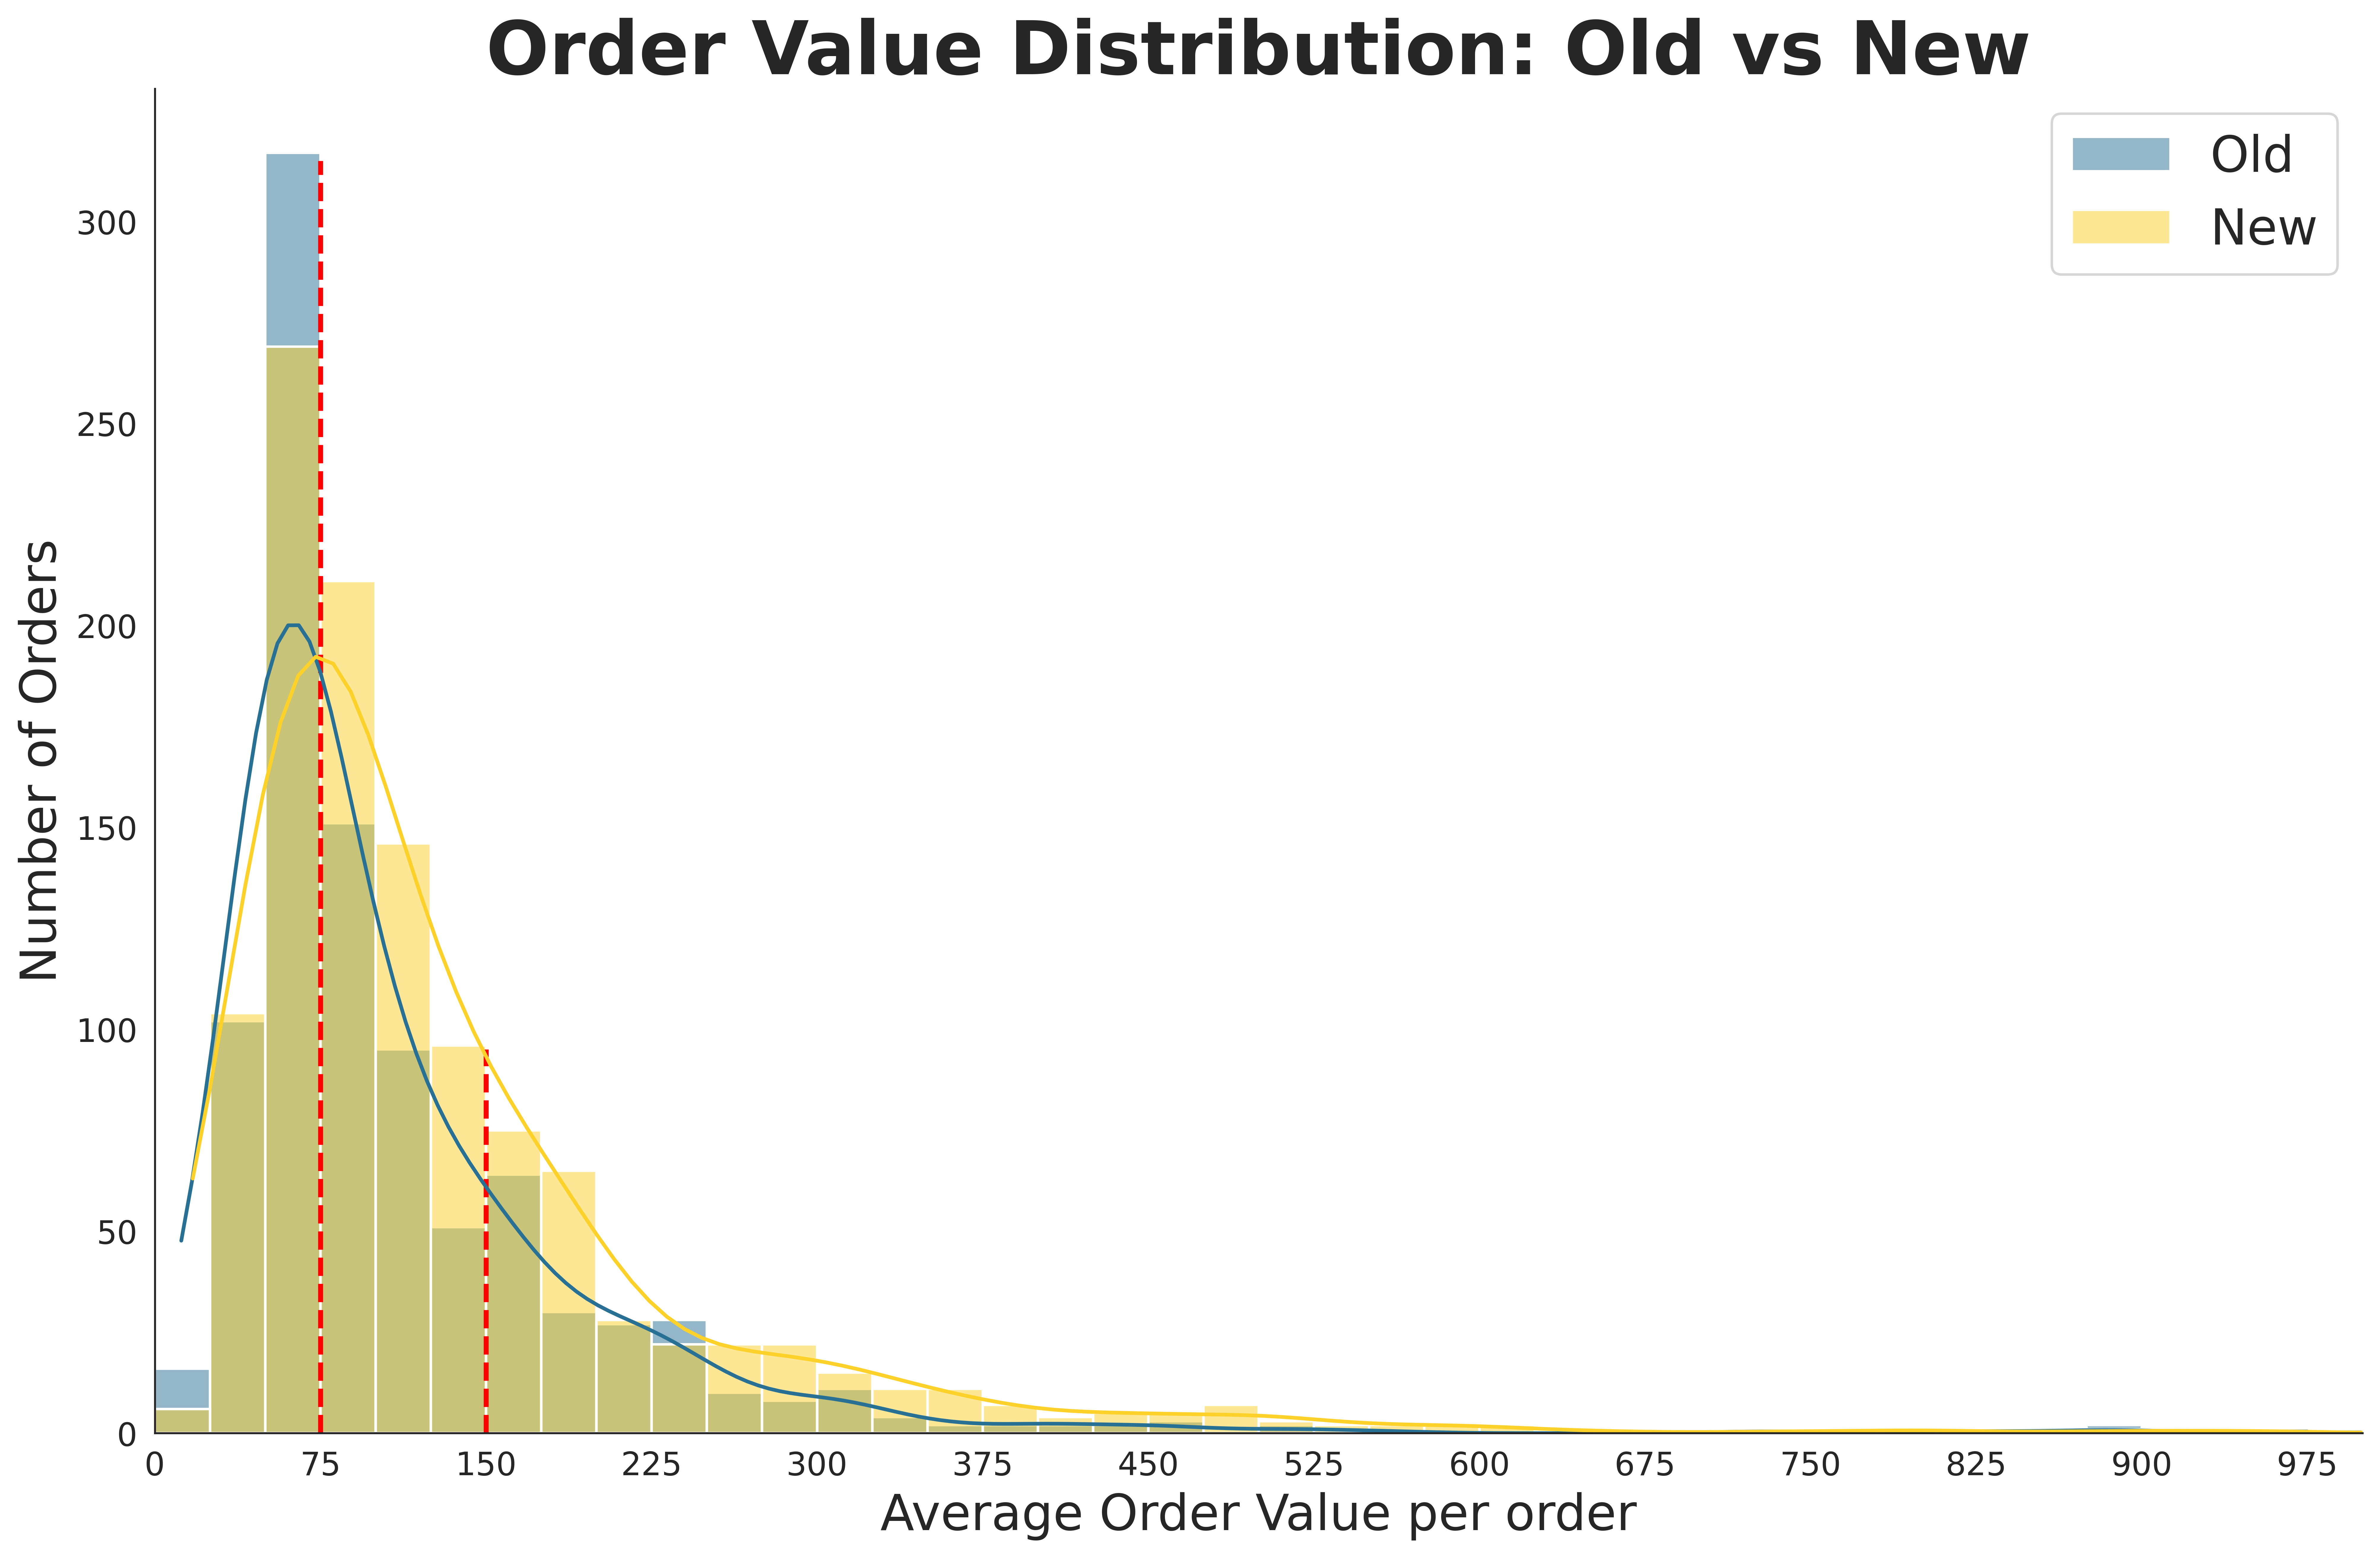

In [16]:
figure = plt.figure(figsize = (16,10))

sns.set_style('white')
ax = sns.histplot(old,alpha = 0.5,label='Old',color = '#287094',kde=True, binrange = (0,1000),bins=40)
sns.histplot(new,alpha = 0.5,label='New',color = '#fcd12a',kde=True,binrange = (0,1000),bins=40)
plt.legend(prop={'size':20})
plt.title('Order Value Distribution: Old vs New',fontsize = 30,fontweight='bold')
plt.xlabel('Average Order Value per order',fontsize = 20)
plt.ylabel('Number of Orders',fontsize = 20)
plt.xticks(np.arange(0,1000,50),fontsize = 13)
plt.xlim(0,1000)
plt.xticks(np.arange(0,1000,75),fontsize = 13)
plt.vlines(75,ymin=0,ymax=315,colors='red',linestyles = 'dashed', linewidth = 2)
plt.vlines(150,ymin = 0,ymax = 95, colors='red',linestyles='dashed',linewidth = 2)
plt.yticks(fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


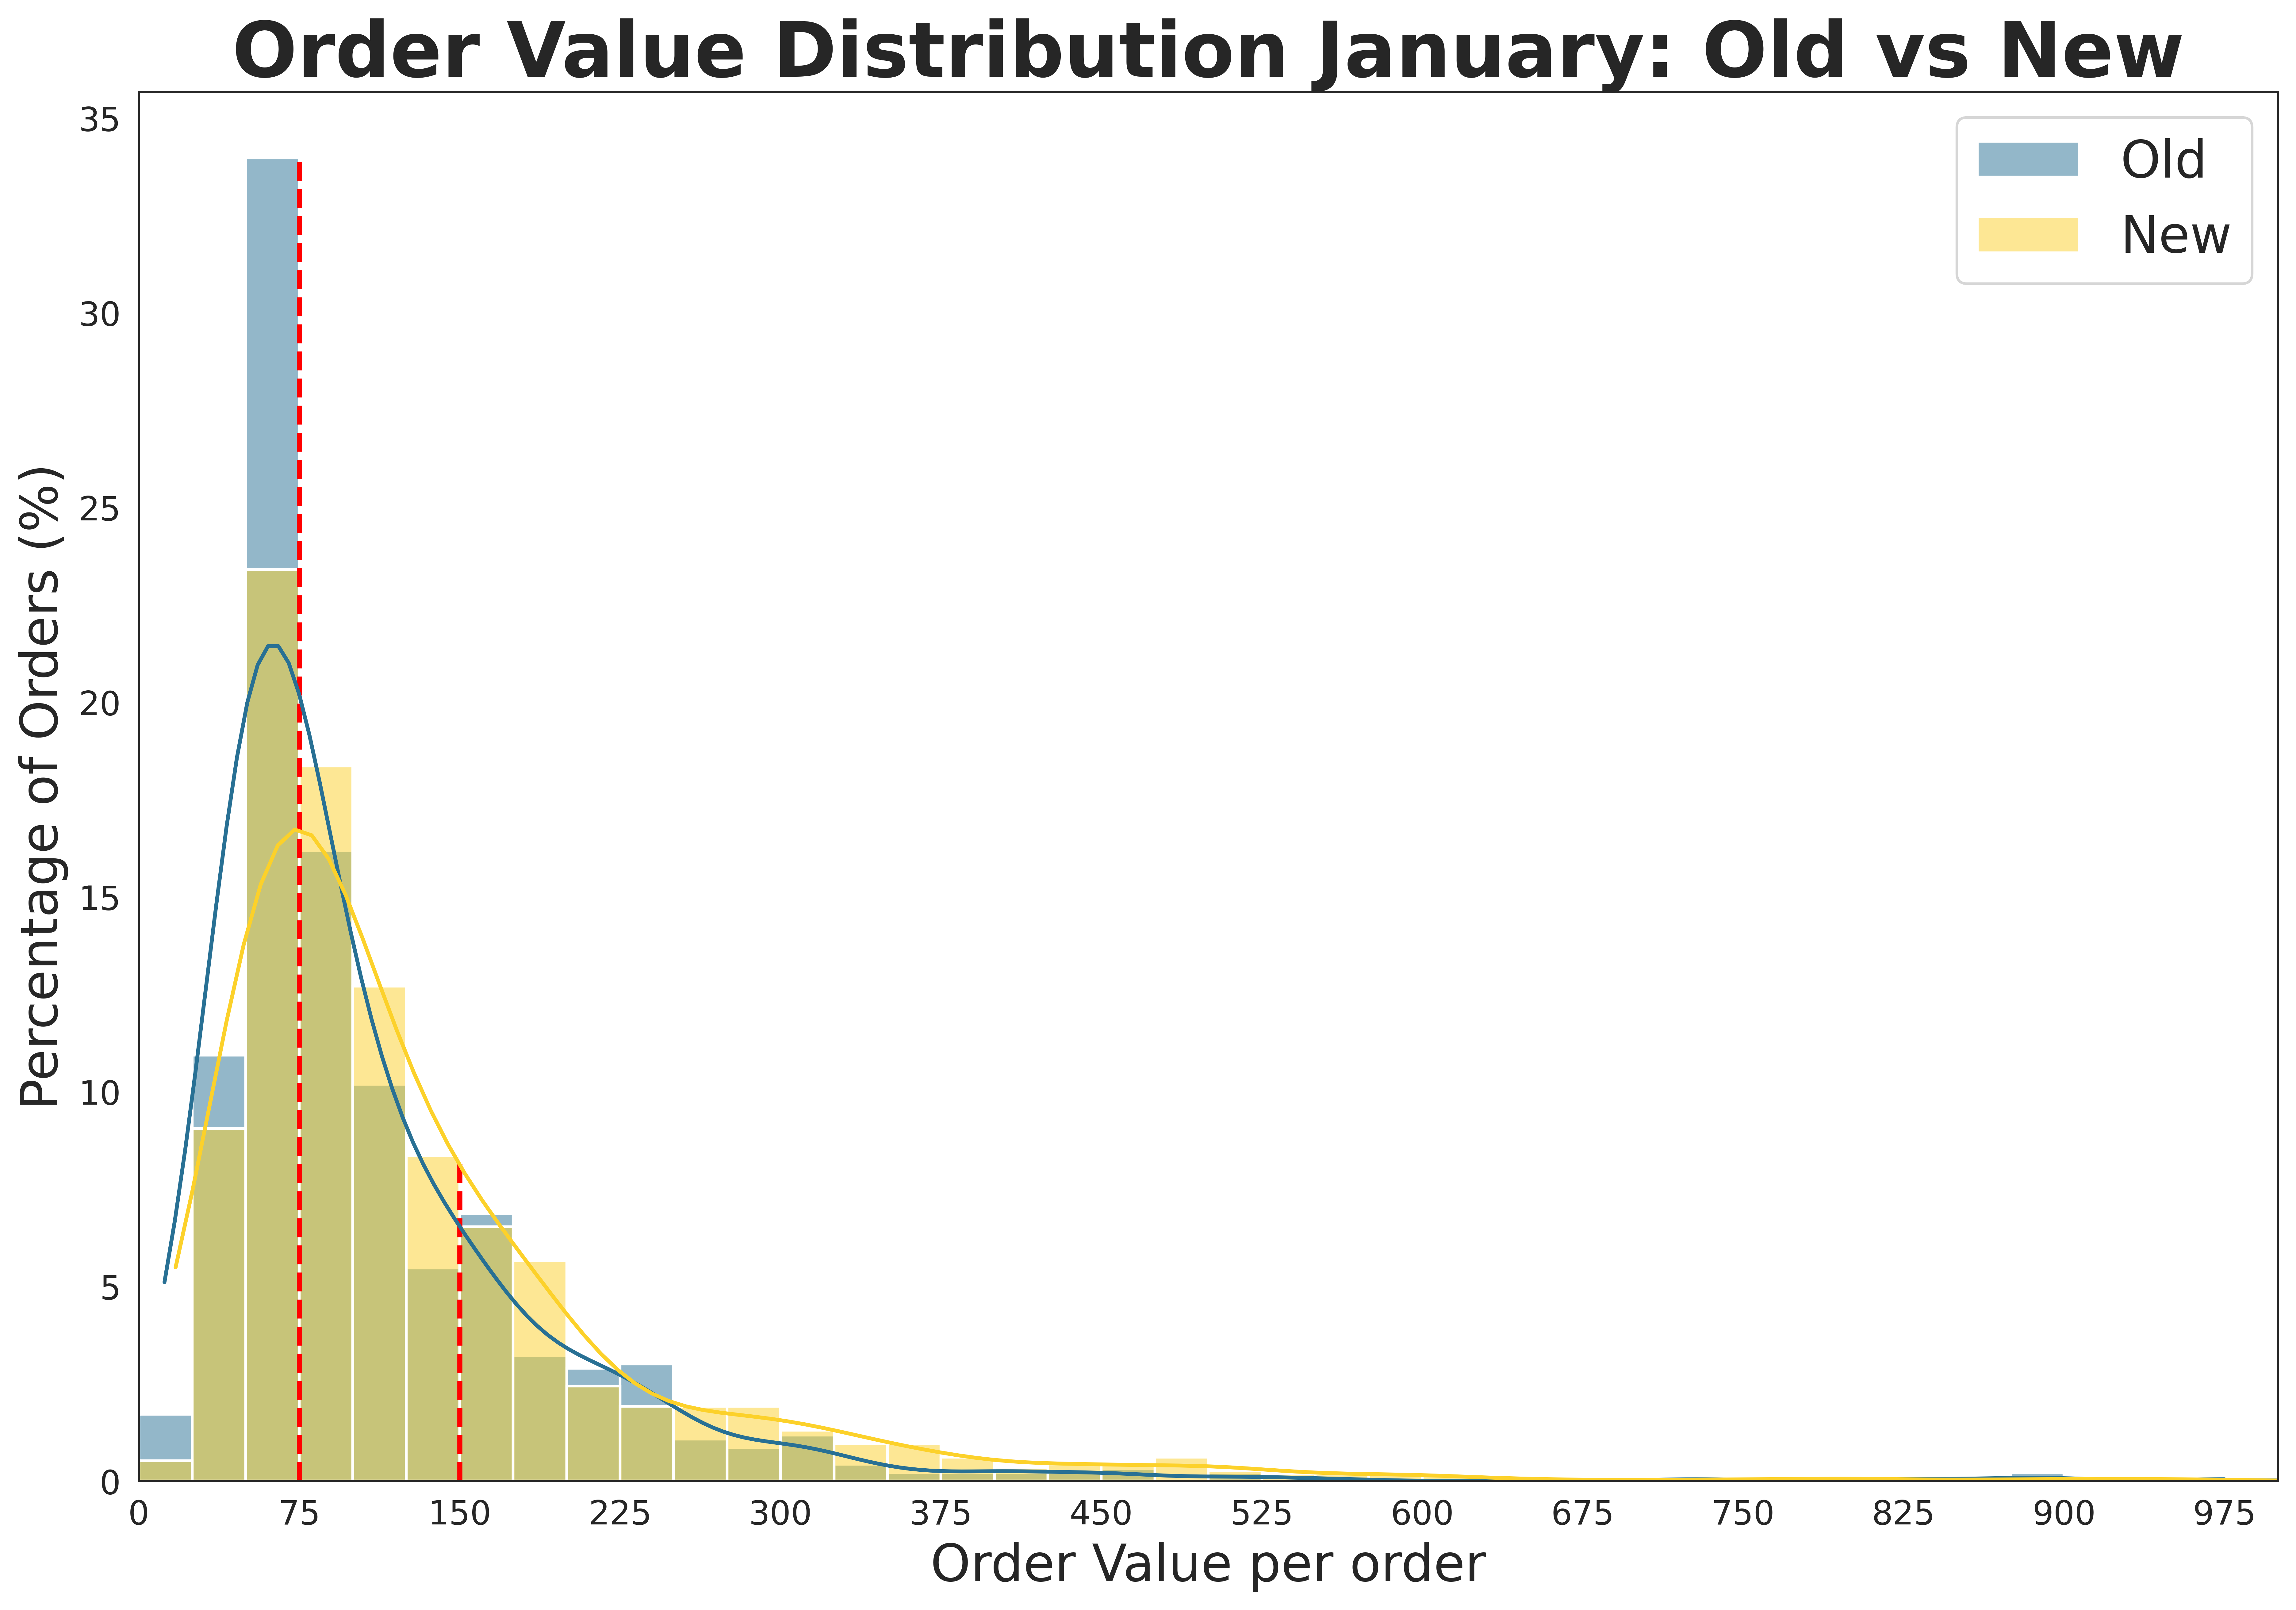

In [17]:
figure = plt.figure(figsize = (15,10))
ax = plt.subplot()
sns.set_style('white')
sns.histplot(old,alpha = 0.5,label='Old',color = '#287094',kde=True, binrange = (0,1000),bins=40,stat = 'percent')
sns.histplot(new,alpha = 0.5,label='New',color = '#fcd12a',kde=True,binrange = (0,1000),bins=40,stat = 'percent')
plt.legend(prop={'size':20})
plt.title('Order Value Distribution January: Old vs New',fontsize = 30,fontweight='bold')
plt.xlabel('Order Value per order',fontsize = 20)
plt.ylabel('Percentage of Orders (%)',fontsize = 20)
plt.xticks(np.arange(0,1000,50),fontsize = 13)
plt.xlim(0,1000)
plt.xticks(np.arange(0,1000,75),fontsize = 13)
plt.vlines(75,ymin=0,ymax=33.9,colors='red',linestyles = 'dashed', linewidth = 2)
plt.vlines(150,ymin = 0,ymax = 8.3, colors='red',linestyles='dashed',linewidth = 2)
plt.yticks(fontsize = 13)
plt.savefig('average_order_value_2021_2022_percent.png')

### I also created two pie charts showing a order value breakdown to the old and new version below

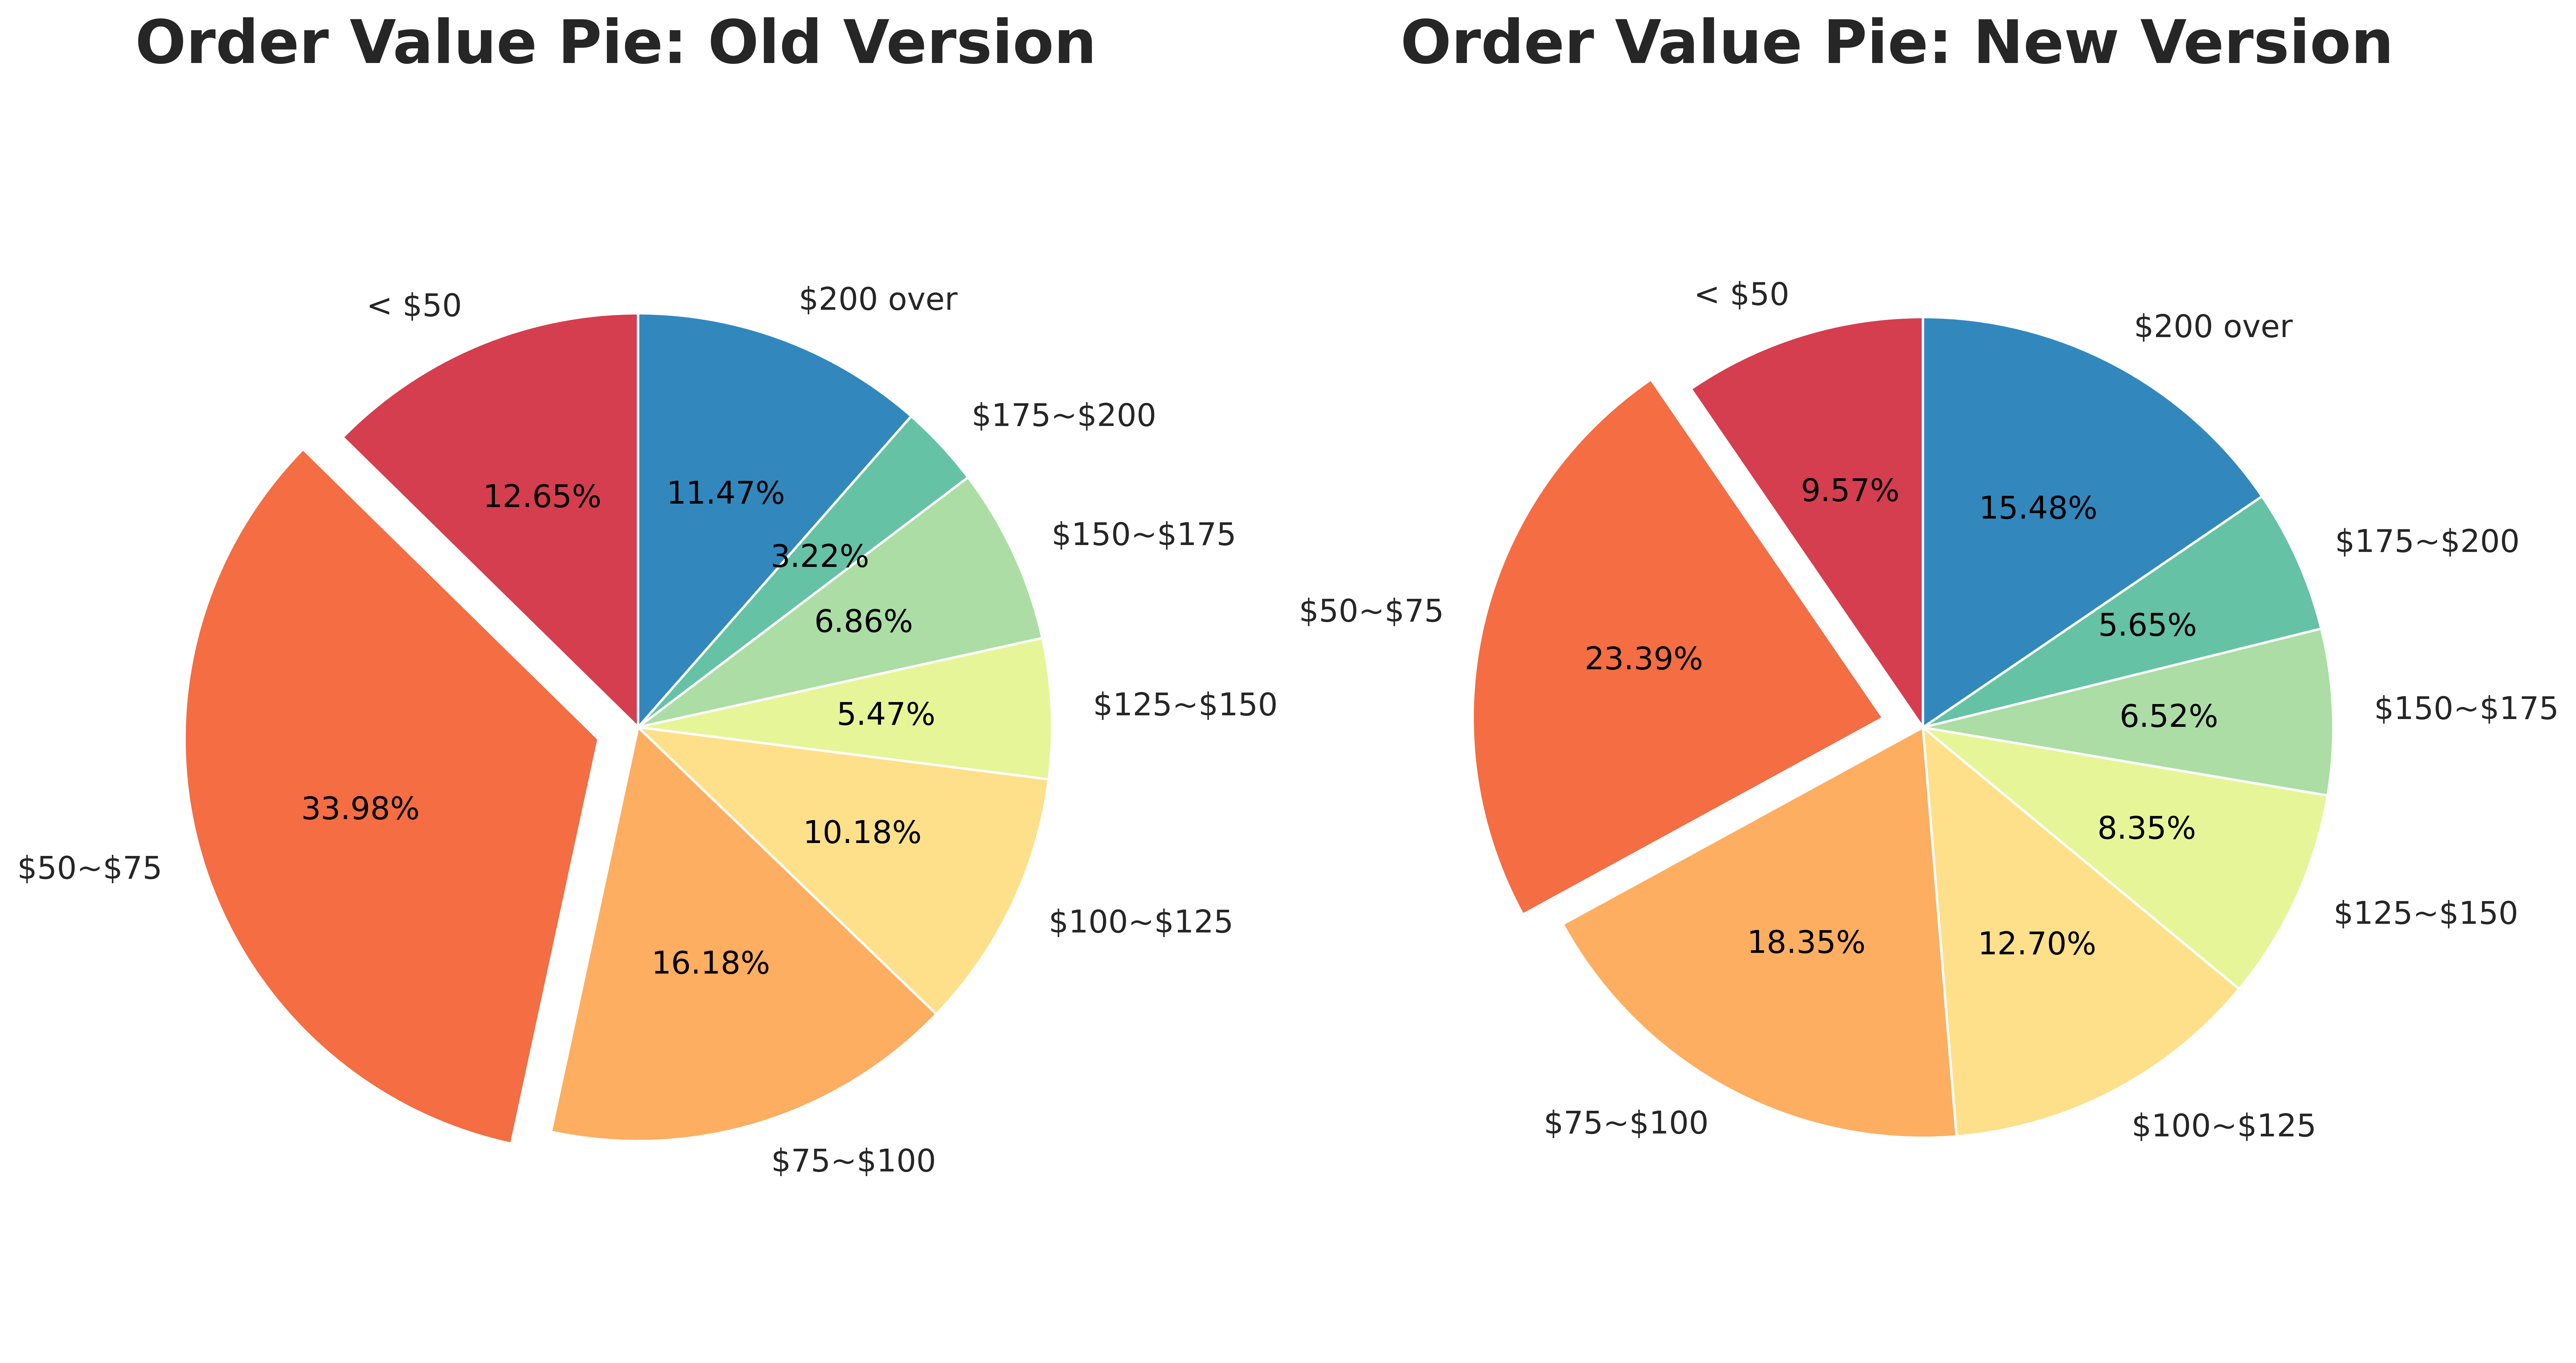

In [18]:
plt.figure(figsize = (15,8))

plt.subplot(1,2,1)
labels2 = ['< $50','\$50~$75',"\$75~$100",'\$100~$125','\$125~$150','\$150~$175','\$175~$200','\$200 over'] 
count3 = [118,317,151,95,51,64,30,107]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
explode = [0,.1,0,0,0,0,0,0]
patches, texts, autotexts = plt.pie(count3,labels = labels2,wedgeprops = {'linewidth':1,'edgecolor':'white'}, textprops = {'size': 13},autopct = '%.2f%%',colors = color_pie,explode=explode,startangle=90)
plt.setp(autotexts,color = 'black',size='13')
plt.title('Order Value Pie: Old Version',fontsize=25,fontweight='bold',y=1.03)
plt.axis('equal')
plt.tight_layout()

plt.subplot(1,2,2)
labels2 = ['< $50','\$50~$75',"\$75~$100",'\$100~$125','\$125~$150','\$150~$175','\$175~$200','\$200 over'] 
count2 = [110,269,211,146,96,75,65,178]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
explode = [0,.1,0,0,0,0,0,0]
patches, texts, autotexts = plt.pie(count2,labels = labels2,wedgeprops = {'linewidth':1,'edgecolor':'white'}, textprops = {'size': 13},autopct = '%.2f%%',colors = color_pie,explode=explode,startangle=90)
plt.setp(autotexts,color = 'black',size='13')
plt.title('Order Value Pie: New Version',fontsize=25,fontweight='bold',y=1.03)
plt.axis('equal')
plt.tight_layout()


### **Insight & Recommendations**
1. Newly updated free shipping threshold and shipping rates made a significant contribution to higher AOV and revenue. The result also showed that ecommerce shipping strategy is a key to our online store’s success that can change our consumer behaviors effectively.

2.	We should offer low-priced but appealing accessories (price range \$0 ~ \$25) in order to nudge more customers from the \$50-\$75 bucket to higher buckets beyond \$75 since consumers wouldn’t want to pay more than \$10- \$15 to get free shipping.  However, our current offering under \$100 is as below. Practically, chain extender and 1.2” bead chains are the only valid options to add to their carts considering that the average price in the \$25- \$50 bucket is \$39.43 which is too high. If we can encourage another 10% of the $50 -$75 bucket orders to the \$75 - \$100 by nudging them to buy accessories (\$1 - \$25), then we can have at least $12.5 upsell value per item.  



Price Range    | Quantity          |Items
-------------------|--------------------|-----  
< \$10     |1 |ECOM Packging -\$0
\$10~\$25      | 3|\$10 gift card, Chain extender, 1.2 bead chain
\$25~\$50|136|Average price: \$39.43
\$50~\$75	|171|
\$75~\$100	|213|








# **b. Conversion Rate**

As expected, the conversion rate decreased by 26% from 1.29% to 0.95%. The difference is significantly different (p-value: 0.0000392). 

|   | 2021      |2022|Growth Rate
-------------------|--------------------|-----|----------  
Average Conversion Rate(%)     |1.29 |0.95%|-26%

In [30]:
year_month(conversion)
year_month_day(conv_day)
jf_2021 = conv_day[(conv_day['year'] == '2021') & ((conv_day['month'] == '01')|(conv_day['month'] == '02'))]
jf_2022 = conv_day[(conv_day['year'] == '2022') & ((conv_day['month'] == '01')|(conv_day['month'] == '02'))]
conv_2021 = jf_2021.total_conversion
conv_2022 = jf_2022.total_conversion
ttest, pval  = ttest_ind(conv_2021,conv_2022)
print(f'p-value for 2-sample t-test is {pval}')

p-value for 2-sample t-test is 3.93194356226244e-05


Text(0.5, 1.0, 'Conversion Rate for old version and new version')

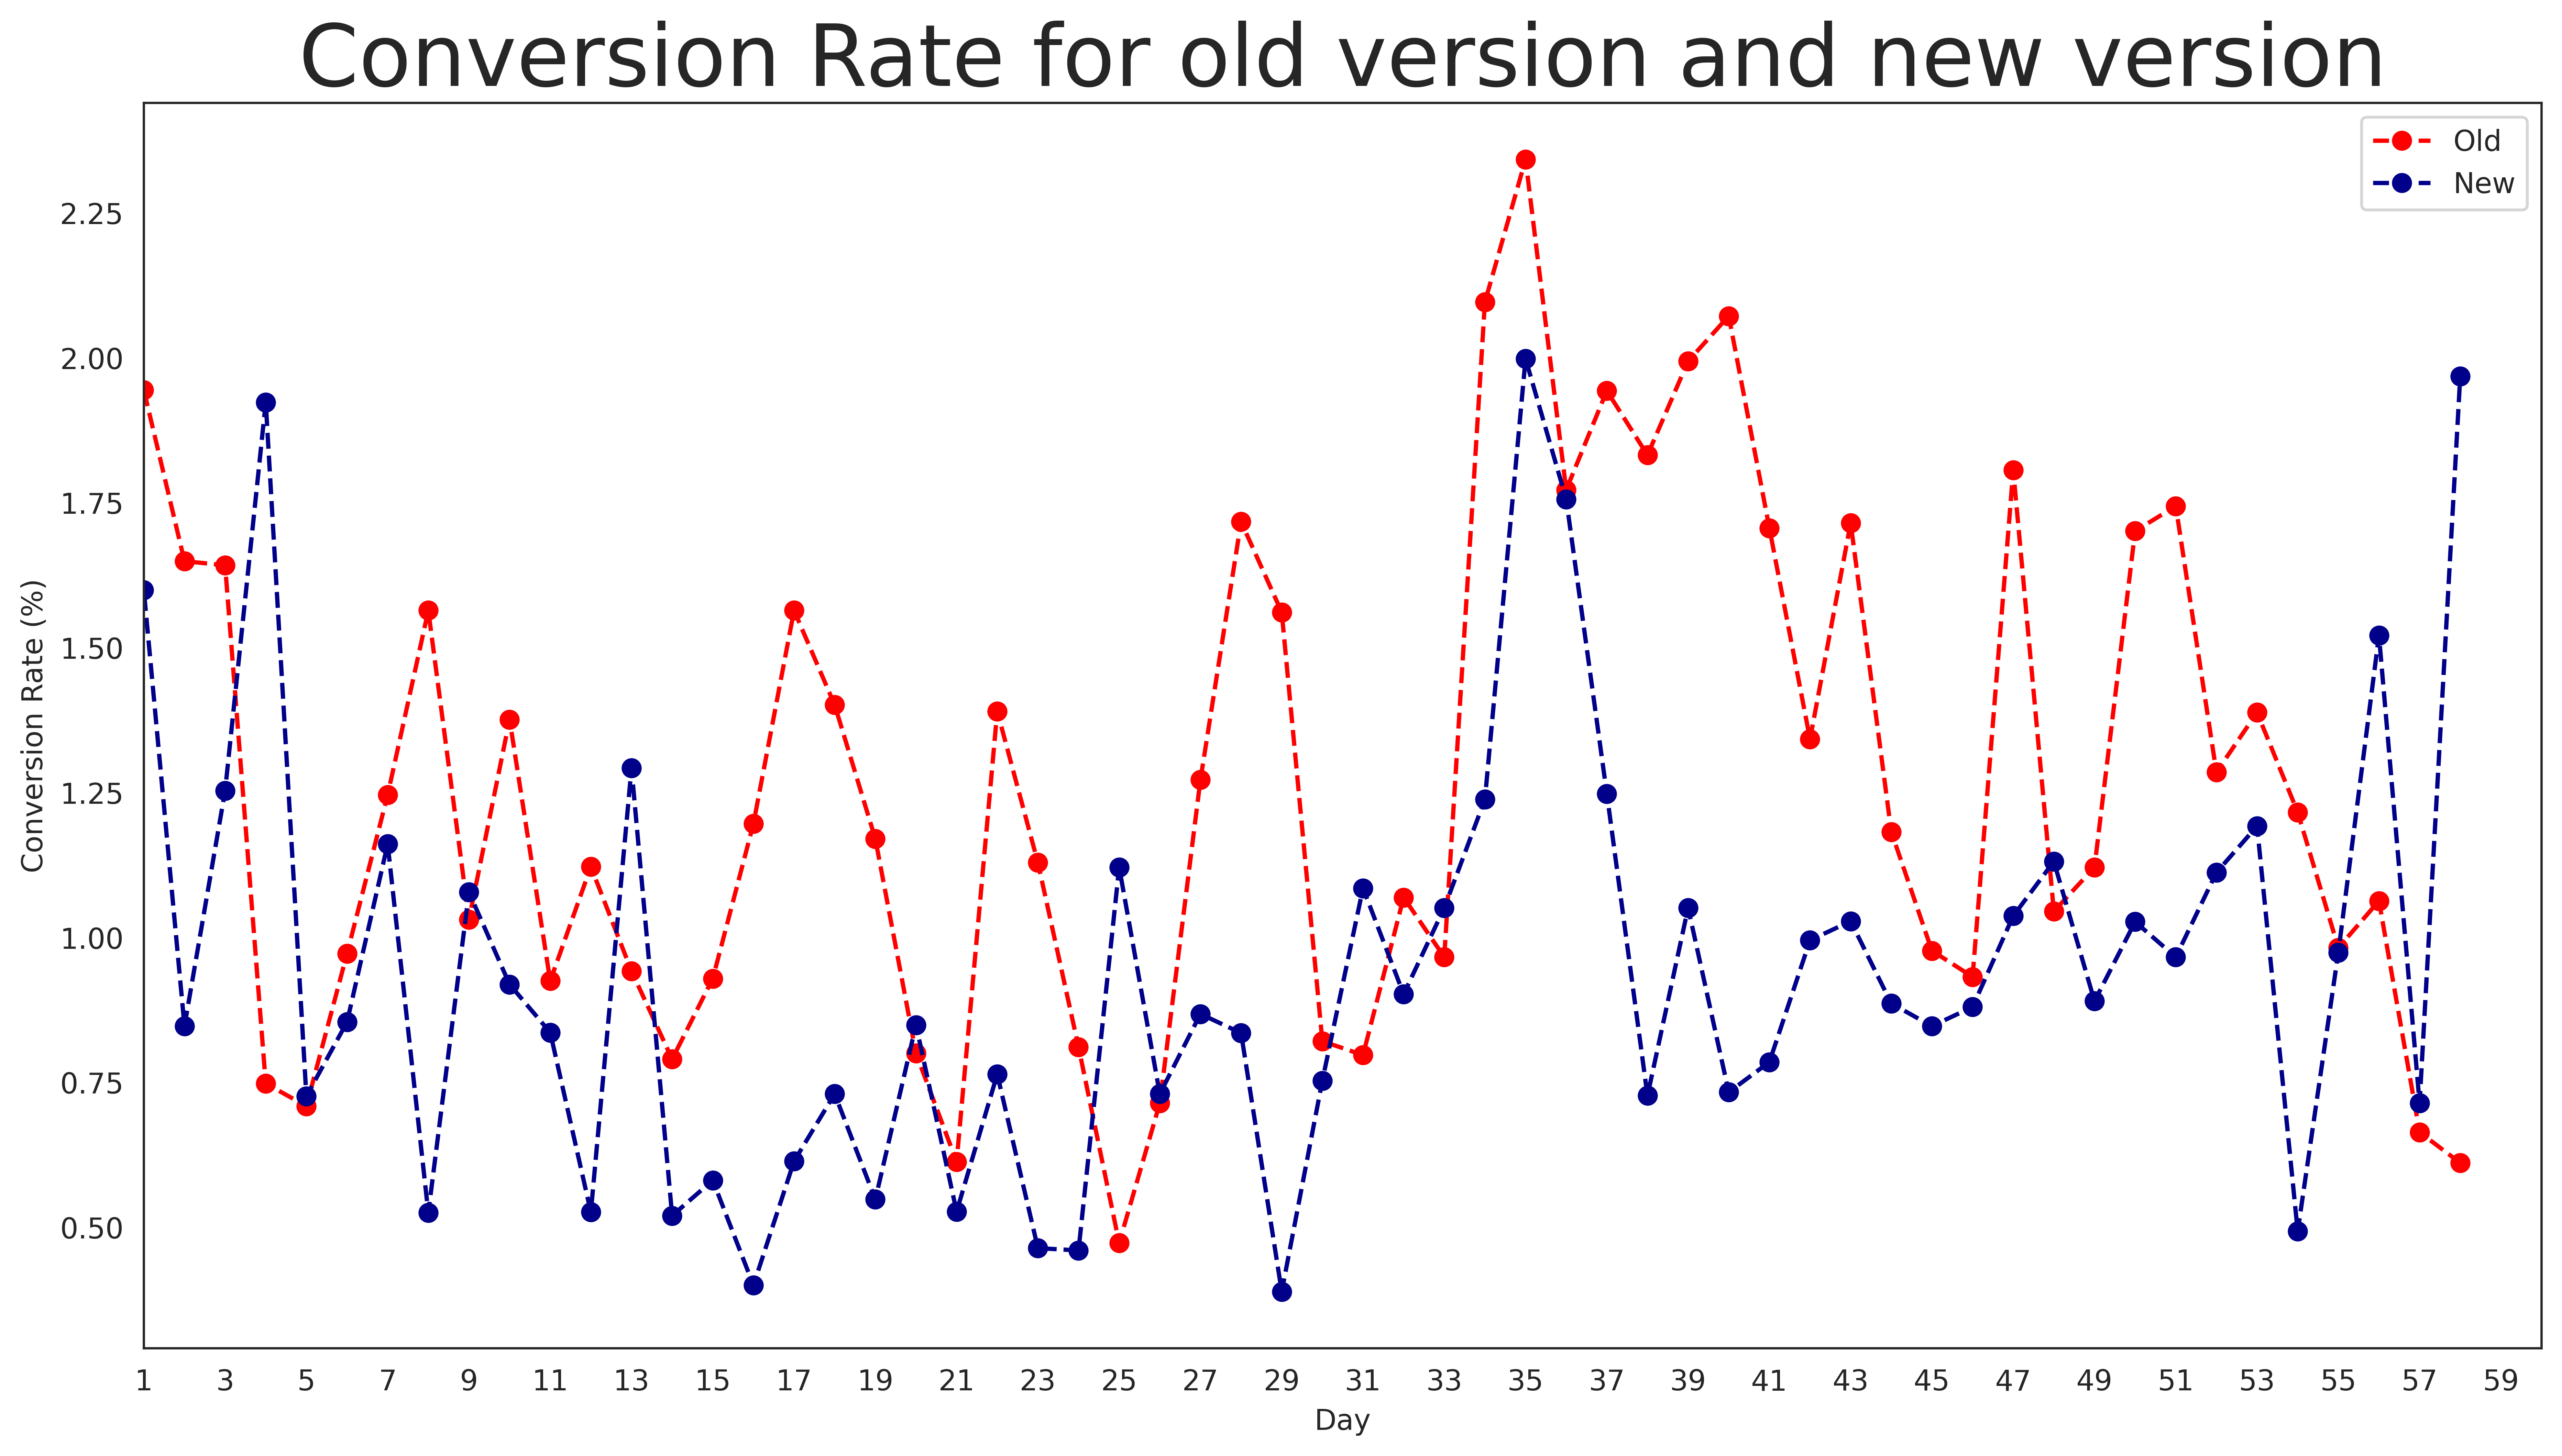

In [31]:
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(conv_2021.reset_index().index,conv_2021.reset_index()['total_conversion']*100,marker = 'o',color='red',linewidth = 1.5,linestyle = 'dashed', )
plt.plot(conv_2022.reset_index().index,conv_2022.reset_index()['total_conversion']*100,marker = 'o',color = 'darkblue',linewidth = 1.5,linestyle = 'dashed')
plt.xlabel('Day')
plt.ylabel('Conversion Rate (%)')
plt.legend(['Old','New'])
plt.xlim(1,60)
plt.xticks(np.arange(1,60,2))
plt.title('Conversion Rate for old version and new version',fontsize = 30,fontname = 'Staatliches')


### **Insight & Recommendations**
The conversion rate decreased but we have to find a point at which the decrease occur.  It is known that high shipping costs will increase cart or checkout abandonment. However, since our website doesn’t display a shipping cost on the cart stage, checkout abandonment would be a better metric to use to evaluate the effect of the updated shipping plan. 

Please see below conversion rates for each step of our consumer’s buying journey. 

Interestingly, the checkout conversion rate (checkout to sales) decreased only by 1.33% from 52.42% to 52.71%. Instead, the session conversion rate (sessions to carts) and cart conversion rate (cart to checkout) decreased by 14.31% and 12.60% , respectively. It seems like the new shipping option didn’t discourage to abandon orders at checkout that much at least for this dataset while the cart and session abandonment is something that we might want to look at. The conversion rate drop on these steps come from many factors so this could be another topic to study. 


Steps    | Count          |Conversion Rate  
-------|---------|------
< total_sessions   |65,594 |6.01%
total_carts      | 3,944|39.30%
total_checkouts|1,550|53.42%
total_orders_placed	|828|


Steps    | Count          |Conversion Rate  
-------|---------|------
< total_sessions   |104,406 |5.15%
total_carts      | 5,380|34.35%
total_checkouts|1,848|52.71%
total_orders_placed	|974|
